# Development Notebook for IFAT Simulator

In [1]:
from brian2 import *
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def visualize_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [3]:
MODE = 'adaptive'
PARASITICS = True

In [4]:
# Define various equations

if MODE == 'adaptive':
    neuron_eq = '''
        dVm/dt = ((glm + gpar) / Cm) * (Vm_r - Vm)  : volt
        dVt/dt = ((glt + gpar) / Ct) * (Vt_r - Vt)  : volt
        
        # dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt
        # dVt/dt = (glt / Ct) * (Vt_r - Vt) : volt

        glm = flm * Cl                              : siemens
        glt = flt * Cl                              : siemens
        gpar = par_ctrl / par_leak_time * Cm : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
        Vt = Vt * (Vt > Vm) + Vt_r * (Vt <= Vm)
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
        Vt += (Cst/Ct) * (Vm_old - Vm_r)
    '''
else:
    neuron_eq = '''
        dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt

        glm = flm * Cl                    : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
    '''

# Synapse equation is the same for both modes!
syn_eq = '''
    Vsyn = (W/Cm)*(Em - Vm) : volt
    Em                      : volt
    W                       : farad
'''

In [5]:
# IFAT specific definitions
Vdd = 5 * volt
Cm = Ct = 0.44 * pF
Cl = 0.02 * pF

W_vals  = np.array([5, 10, 20, 40, 80]) * 0.001 * pF
Em_vals = np.array([0, 1/3, 2/3, 1]) * Vdd

par_ctrl = True
par_ctrl = float(PARASITICS)
par_leak_time = 12.5 * ms

In [6]:
# Model parameters
Vm_r = 1.25 * volt
flm  = 0 * kHz
Csm  = W_vals[0]

Vt_r = 3 * volt
flt  = 0 * MHz
Cst  = 0 * pF

N = 4

In [ ]:
start_scope()
defaultclock.dt = 0.2 * us

In [ ]:
# Start stuff up, brochacho
test = NeuronGroup(N, neuron_eq, threshold='Vm > Vt', reset=reset_eq, method='exact')
test.Vm = Vm_r
test.Vt = Vt_r

In [ ]:
bg_rate = 6*kHz
bg_spk_times = np.arange(0,0.1,Hz/bg_rate) * second
bg_spk_inds  = np.zeros_like(bg_spk_times)
#bg_spks = PoissonGroup(1,rates=bg_rate)
bg_spks = SpikeGeneratorGroup(1,bg_spk_inds,bg_spk_times)

bg_syn = Synapses(bg_spks, test, syn_eq, on_pre=presyn_eq)
bg_syn.connect()
bg_syn.delay = "j * 0.2 * us"
bg_syn.Em = Em_vals[2]
bg_syn.W  = W_vals[3] + W_vals[2] + W_vals[0]

# inp_rate = 500 * Hz
# inp_spk_times = np.arange(0,0.1,Hz/inp_rate) * second
# inp_spk_inds  = np.zeros_like(inp_spk_times)
# inp_spks = SpikeGeneratorGroup(1, inp_spk_inds, inp_spk_times)

# inp_syn = Synapses(inp_spks, test, syn_eq, on_pre=presyn_eq)
# inp_syn.connect()
# inp_syn.Em = Em_vals[2]
# inp_syn.W  = sum(W_vals)

exc_syn = Synapses(test, test, syn_eq, on_pre=presyn_eq)
exc_syn.connect('j==((i+1)%(4))')
#exc_syn.connect('j==i')
exc_syn.Em = Em_vals[3]
exc_syn.W  = sum(W_vals[0:2])

inh_syn = Synapses(test, test, syn_eq, on_pre=presyn_eq)
inh_syn.connect('j==((i+2)%4)')
inh_syn.connect('j==((i+3)%4)')
inh_syn.Em = Em_vals[0]
inh_syn.W  = sum(W_vals)*2

In [ ]:
#visualize_connectivity(inh_syn)

In [ ]:
#visualize_connectivity(exc_syn)

In [ ]:
sp_mon = SpikeMonitor(test)
vm_mon = StateMonitor(test, 'Vm', record=True, dt=0.1*ms)
vt_mon = StateMonitor(test, 'Vt', record=True, dt=0.1*ms)
ratemon = PopulationRateMonitor(test)

In [ ]:
run(100*ms,report='text')

In [ ]:
for i in range(N):
    plot(vm_mon.t/ms, vm_mon.Vm[i]/volt,vt_mon.t/ms, vt_mon.Vt[i]/volt)
xlim([0,100])

In [ ]:
plot(vm_mon.t, vm_mon.Vm[1]/volt,vt_mon.t, vt_mon.Vt[0]/volt); xlim([0,0.1]);
plot(sp_mon.t, sp_mon.i*3,'.k')
ylim([0,4])

In [ ]:
plot(sp_mon.t, sp_mon.i, '.g'); #xlim([0.062,0.082]);

In [ ]:
plot(ratemon.t/ms, ratemon.smooth_rate(width=10*ms)/Hz)

In [ ]:
len(sp_mon.i[sp_mon.i==0])

## Trying the Zilli & Hasselmo Approach
Above, we're able to get a sort of ring oscillator concept working. Below, we'll try the Zilli and Hasselmo approach of coupling "noisy cells" to form an oscillator (where we work out the interpolated Frequency/Input curve to find the necessary inputs)

In [ ]:
start_scope()

In [ ]:
zilli = NeuronGroup(100, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')

In [ ]:
zilli.Vm = Vm_r
zilli.Vt = Vt_r

In [ ]:
zilli_syn = Synapses(zilli, zilli, syn_eq, on_pre=presyn_eq)
zilli_syn.connect()
zilli_syn.Em = Em_vals[3]
zilli_syn.W = sum(W_vals)

In [ ]:
stim_rate = 300*Hz
stim_spk_times = np.arange(0,0.2,Hz/stim_rate) * second
stim_spk_inds  = np.zeros_like(stim_spk_times)
#stim_spks = PoissonGroup(1,rates=stim_rate)
stim_spks = SpikeGeneratorGroup(1,stim_spk_inds,stim_spk_times)

stim_syn = Synapses(stim_spks, zilli, syn_eq, on_pre=presyn_eq)
stim_syn.connect()
stim_syn.delay = "j * 0.2 * us"
stim_syn.Em = Em_vals[3]
stim_syn.W  = W_vals[3] + W_vals[2] + W_vals[0]

In [ ]:
zspmon = SpikeMonitor(zilli)
zmon = PopulationRateMonitor(zilli)

In [ ]:
run(0.2*second, report='text')

In [ ]:
subplot(121)
plot(zspmon.t/ms, zspmon.i,'.')
subplot(122)
plot(zmon.t/ms, zmon.smooth_rate(width=10*ms))

## Trying the *Other* Tad Blair approach

In [7]:
def calc_weight(M, alpha, mu, sigma):
    output = zeros((M,M))
    for i in np.arange(M):
        for j in np.arange(M):
            output[i,j] = exp(cos((2*pi*i/M) - (2*pi*j/M) - mu)/sigma**2)
    output = output * (alpha/np.max(output))
    output = 5.0 * fF * np.around(output/(5.0*fF))
    return output

In [12]:
M = 108
alpha = sum(W_vals)
mu1 = 0
mu2 = 2*pi/3
sigma = 27 * pi/180
fF = 0.001 * pF

In [13]:
check = calc_weight(M,alpha,mu1,sigma)

In [14]:
check[10,1]

85. * ffarad

In [54]:
start_scope()

In [55]:
defaultclock.dt = 0.1* ms

In [56]:
blair_exc = NeuronGroup(M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
blair_inh = NeuronGroup(M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')

In [57]:
blair_exc.Vt = Vt_r
blair_inh.Vt = Vt_r
blair_exc.Vm = Vm_r
blair_inh.Vm = Vm_r

In [58]:
exc2inh = Synapses(blair_exc, blair_inh, syn_eq, on_pre=presyn_eq)
exc2inh.connect()
exc2inh.Em = Em_vals[2]

exc2inh.W = calc_weight(M,alpha,mu1,sigma).flatten()

In [59]:
inh2exc = Synapses(blair_inh, blair_exc, syn_eq, on_pre=presyn_eq)
inh2exc.connect()
inh2exc.Em = Em_vals[0]
inh2exc.W  = calc_weight(M,alpha,mu2,sigma).flatten()

In [60]:
inh2inh = Synapses(blair_inh, blair_inh, syn_eq, on_pre=presyn_eq)
inh2inh.connect()
inh2inh.Em = Em_vals[0]
inh2inh.W = calc_weight(M,alpha,mu1,sigma).flatten()

In [61]:
PoisIn = PoissonGroup(M,rates=0.6*kHz)

In [62]:
p2exc = Synapses(PoisIn, blair_exc, syn_eq, on_pre=presyn_eq)
p2exc.connect('j==i')
p2exc.Em = Em_vals[3]
p2exc.W = sum(W_vals[0:3])

In [63]:
i_spmon = SpikeMonitor(blair_inh)
e_spmon = SpikeMonitor(blair_exc)
e_vmon = StateMonitor(blair_exc, 'Vm', record=True)
erate0 = PopulationRateMonitor(blair_exc[:1])
erate1 = PopulationRateMonitor(blair_exc[1:2])
erate10 = PopulationRateMonitor(blair_exc[10:11])
erate20 = PopulationRateMonitor(blair_exc[20:21])
irate = PopulationRateMonitor(blair_inh)

In [64]:
run(5*second,report='text')

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block tha

Starting simulation at t=0. s for a duration of 5. s
5.0 (100%) simulated in 6s


(2000, 2500)

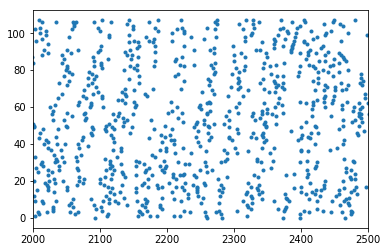

In [67]:
plot(e_spmon.t/ms, e_spmon.i,'.');xlim([2000,2500])